In [75]:
import numpy as np
from matplotlib import pyplot as plt
import csv
from datetime import datetime, timedelta
import nbconvert

Modifiable Parmas
==================

Change the parameters in the following cell to change properties of the plot at the bottom

In [76]:
field = ['cases', 'deaths'][0] # switch index to do cases vs deaths
# Note that as of April 29, "deaths" are noisy for states other than, e.g., New York, New Jersey

# set to False to sort based on absolute case or death count
# set to True to sort (and plot) based on per-100k case or death count
per_capita = False
per_capita =  True

# Data for low population counties can get noisy.
# This flag allows one to drop counties with population below a threshold
# Only active when per_capita is True
population_drop_thresh = 60000

# state = "Georgia" # switch to, e.g., 'New York'
# set to None to view the top counties in the entire US
# e.g.
state = None
# set to a list to aggregate all counties from all states in the list
# e.g.
# state = ['Virginia', 'Maryland', 'District of Columbia']
# state = ["California", "Virginia"]
# state = ["Georgia", "New Mexico"] # for a selection of rural counties with outbreaks
# state = ["New Mexico", "Arizona", "Colorado", "Nevada"]

magic_date = "2020-04-24" # date to highlight on plots
# Uncomment any of the lines below to use that date as the magic date
# magic_date = "2020-03-19" # is the start of the California Shelter-In-Place
# magic_date = "2020-03-17" # is the start of the Bay Area Shelter-In-Place
# magic_date = "2020-03-20" # is the start of the New York State SIP
# magic_date = "2020-03-30" # is the DC/Maryland/Virginia SIP
# magic_date = "2020-03-31" # is the Tennessee SIP start
# magic_date = "2020-04-07" # is the infamous Wisconsin election
# magic_date = "2020-04-24" # is the Georgia re-opening date
# magic_date = "2020-05-01" # is the Texas re-opening date
# magic_date = "2020-05-12" # Wisconsin court-ordered re-opening

# It takes a while for policy changes to be reflected in the data,
# so we plot markers at some number of days after the magic date
# The following is a list of delays at which to place markers
offset_magic_date_by = [5, # estimated incubation period of COVID-19
                        12, # a few days after estimated incubation period of COVID-19
                       ]
# make this list empty to eliminate all magic date markers
# e.g.
offset_magic_date_by = []

# Sometimes, in addition to top counties, you also want to compare particular counties.
# This is most useful when doing per 100k on the whole country
extra_counties = []
# extra_counties = ["Catoosa"]
# extra_counties = ["Santa Clara", "San Francisco", "San Mateo", "Alameda", "Contra Costa", "Sacramento"]
# extra_counties = ["Prince George's", "Los Angeles", "Fairfax", "District of Columbia"]
# extra_counties = ["Santa Clara", "Sacramento", "Dougherty", "Snohomish", "New York City", "Los Angeles", "Cook"]
extra_counties = ["McKinley", "Apache", "Cook", "Los Angeles"]

show_this_many_counties = 12 # You probably don't want to exceed 12 here

In [77]:
# The following are paremeters affecting how the program displays and computes data
smoothing_window = 7 # use any positive integer, but values above 5 work best
magic_date_marker_size = 20


Read the data
=============

Code and helper utils for actually ingesting the data

In [78]:
fname = "covid-19-data/us-counties.csv"
pop_data_fname = "us-census-data/county_data.csv"

In [79]:
county_pops = {}
csv_reader = csv.DictReader(open(pop_data_fname, 'r', newline='', encoding='ISO-8859-1'))
for entry in csv_reader:
    # print(entry['STNAME'] + " - " + entry['CTYNAME'])
    state_entry = county_pops.get(entry['STNAME'], {})
    county_name = entry["CTYNAME"].replace(" County", "")
    state_entry[county_name] = float(entry["POPESTIMATE2019"])
    county_pops[entry['STNAME']] = state_entry
county_pops["New York"]["New York City"] = 8.399e6
print("LA -> " + str(county_pops["California"]["Los Angeles"]))
print("Catoosa -> " + str(county_pops["Georgia"]["Catoosa"]))

LA -> 10039107.0
Catoosa -> 67580.0


In [80]:
csv_reader = csv.DictReader(open(fname))
data = []
print(state)
for entry in csv_reader:
    if entry['county'].lower() == "unknown":
        continue
    if type(state) == type([]) and not entry['state'] in state:
        continue
    if type(state) == type("") and not entry['state'] == state:
        continue
    raw_pop = county_pops.get(entry['state'], {}).get(entry['county'], 0.0)
    if per_capita:
        if raw_pop <= 0.0 or raw_pop < population_drop_thresh:
            continue
        entry['population'] = raw_pop
    entry['county'] = entry['state'] + " - " + entry['county']
    data.append(entry)


None


In [81]:
def entry_to_days(entry):
    """Converts a YYYY-mm-dd date into an integer with 0 being 2020-01-01"""
    d1 = datetime.strptime(entry['date'], "%Y-%m-%d")
    d0 = datetime.strptime("2020-01-01", "%Y-%m-%d")
    return(d1 - d0).days

def date_from_daynum(daynum):
    return datetime.strptime("2020-01-01", "%Y-%m-%d") + timedelta(days=daynum)
    
# then we convert our magic date to a number
magic_date_nums = [entry_to_days({'date': magic_date}) + i for i in offset_magic_date_by]
magic_date_nums

[]

In [82]:
date_from_daynum(120).strftime("%Y-%m-%d")

'2020-04-30'

In [83]:
# Here we just peek at a cell in the data
data[0]

OrderedDict([('date', '2020-01-21'),
             ('county', 'Washington - Snohomish'),
             ('state', 'Washington'),
             ('fips', '53061'),
             ('cases', '1'),
             ('deaths', '0'),
             ('population', 822083.0)])

In [84]:
# Now we extract data for all counties in this state
counties = {}
for d in data:
    l = counties.get(d['county'], [])
    val = float(d[field])
    if per_capita:
        val = 100000 * val / d['population'] # per 100k
    l.append([entry_to_days(d), val])
    counties[d['county']] = l

In [85]:
len(counties)

848

Code to extract a trajectory for an individual county and plot it
========================

The following functions extract
1. the time series of cumulative caseload for a given county
2. the time series of the average daily change in cumulative caseload over the past "window" days
3. a time series of integers corresponding to number of days after 2020-01-01

and then provide utilities for plotting the average daily change on the y axis
against the cumulative caseload on the x axis on a plot in which each axis
is logarithmically scaled.

Overview of plot meaning
-------------------------------------

For many (but certainly not all) common dynamical systems, a "phase plot" or "phase portrait"
of a time series can be made by plotting a key value of the system on the x axis, plotting
the rate of change of that value on the y axis, and not explicitly plotting time.
(The technical definition of a phase portrait is very different from this,
but the two match up for many of the sorts of systems seen in basic physics).

Such plots highlight certain aspects of a given time series while de-emphasizing others.

In particular, for rapidly growing functions, a phase portrait in which each axis is on
a log scale quickly and easily reveals which family of functions the growth of the quantity
most resembles, rather than what the instantaneous growth rate is.

Purely exponential growth corresponds to lines in this plot with a slope of `1`.
Changing the base of the exponent merely shifts these lines up or down in the plot without
changing their slope.
Quadratic growth corresponds to lines in this plot with a slope of `1/2`.
Polynomial growth with a power of `p` produces lines with a slope of `(p-1)/p`

In [86]:
def trajectory(county, window=5):
    """This just extracts the time series of cumulative caseload, the time series
    of the smoothe (but laggy) rate of change of cumulative caseload, and, to aid
    in marker placement, the time series of date indices (# of days since a reference date)"""
    raw = sorted(counties[county], key = lambda e: e[0])
    date_nums = [raw[i][0] for i in range(window, len(raw))]
    rates = [(float(raw[i][1]) - float(raw[i-window][1])) / (raw[i][0] - raw[i-window][0])
             for i in range(window, len(raw))]
    cums = [float(r[1]) for r in raw[window:]]
    indices = [i for i in range(len(cums)) if cums[i] > 1 and rates[i] > 1]
    if per_capita:
        thresh = 1e4/population_drop_thresh
        indices = [i for i in range(len(cums)) if cums[i] > thresh and rates[i]  > thresh]
    return [[cums[i] for i in indices], [rates[i] for i in indices], [date_nums[i] for i in indices]]

In [87]:
def plot_traj(county, color, window=5, suffix=""):
    """This plots the time series extracted by the
    'trajectory' function on a log/log plot.
    
    It also marks where the trajectory is at any dates
    corresponding to n days after 'magic_date' for each
    n in `offset_magic_date_by`."""
    data = trajectory(county, window=window)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('average new ' + field + suffix + ' per day')
    plt.xlabel('cumulative ' + field + suffix)
    plt.plot(data[0], data[1], color, label=county)
    magic_date_color = color[0] + "o"
    magic_date_index = [i for i in range(len(data[0])) if data[2][i] in magic_date_nums]
    if len(magic_date_index) > 0:
        plt.plot([data[0][i] for i in magic_date_index], [data[1][i] for i in magic_date_index], magic_date_color,
                markersize = magic_date_marker_size)
        # uncomment the next two lines to get a feel for the growth rate via printouts, and double-check estimates
        # of growth rates
        # for i in magic_date_index:
        #    print(county + " on date " + str(i) + " has state " + str((data[0][i], data[1][i])))

In [88]:
def plot_time_series(county, color, window=5, suffix = ""):
    """This plots the time series extracted by the
    'trajectory' function on a log/log plot.
    
    It also marks where the trajectory is at any dates
    corresponding to n days after 'magic_date' for each
    n in `offset_magic_date_by`."""
    data = trajectory(county, window=window)
    plt.yscale('log')
    plt.xscale('linear')
    plt.xlabel('days since 2020-01-01')
    plt.ylabel('cumulative ' + field + suffix)
    plt.plot(data[2], data[0], color, label=county)
    magic_date_color = color[0] + "o"
    magic_date_index = [i for i in range(len(data[0])) if data[2][i] in magic_date_nums]
    if len(magic_date_index) > 0:
        plt.plot([data[2][i] for i in magic_date_index], [data[0][i] for i in magic_date_index], magic_date_color,
                markersize = magic_date_marker_size)


Helper class for grabbing different colors and line styles for plotting

In [89]:
class ColorPicker:
    def __init__(self):
        self.colors = [c + "-" for c in "kbrgcm"] + [c + "--" for c in "kbrgcm"]
        self.i = 0
    def get(self):
        c = self.colors[self.i]
        self.i += 1
        self.i = self.i % len(self.colors)
        return c




THE ACTUAL PLOTS
================

The part you've been waiting for, amirite?

Caveat
------

Right now the naive smoothing method being used causes lag in the "average new cumulative cases per day"

This can cause shifting in these phase plots that will make exponential growth at one rate
look like exponential growth at a slower rate.

I believe that it should still be okay to use this chart to qualitatively determine
1. which counties are experiencing exponential growth
2. which exponential growth trajectories are slower or faster than which other ones

This code snippet also computes most recent approximate doubling times for each county.
These should only be valid for counties for which the cumulative case load is still growing exponentially.

For instance, as of early May, it looked as if this wasn't the case for Dougherty or Sumter counties in Georgia.

This may change, though, for those particular counties.  Georgia is showing strange and fascinating dynamics.

In [90]:
def top_n_from(total_list, def_include_these, n):
    """You want to show n counties, but you want to make sure the ones in
    def_include_these are included.  This is how you do it."""
    def_include_these = [c for c in def_include_these if c in total_list]
    leftover = [c for c in total_list if c not in def_include_these]
    n_to_include = max(0, n - len(def_include_these))
    return leftover[:n_to_include] + def_include_these

New York - Rockland cumulative cases per 100k : 3928.3094272673416
New York - Rockland cumulative cases per 100k currently doubles about once every 208.78 days
Last data entry for New York - Rockland was 2020-05-19
Ohio - Marion cumulative cases per 100k : 3877.529073786736
Ohio - Marion cumulative cases per 100k currently doubles about once every 106.90 days
Last data entry for Ohio - Marion was 2020-05-19
New York - Westchester cumulative cases per 100k : 3348.9197999805688
New York - Westchester cumulative cases per 100k currently doubles about once every 166.61 days
Last data entry for New York - Westchester was 2020-05-19
New Jersey - Passaic cumulative cases per 100k : 3063.013873334582
New Jersey - Passaic cumulative cases per 100k currently doubles about once every 111.42 days
Last data entry for New Jersey - Passaic was 2020-05-19
New York - Nassau cumulative cases per 100k : 2895.8880526838643
New York - Nassau cumulative cases per 100k currently doubles about once every 219.

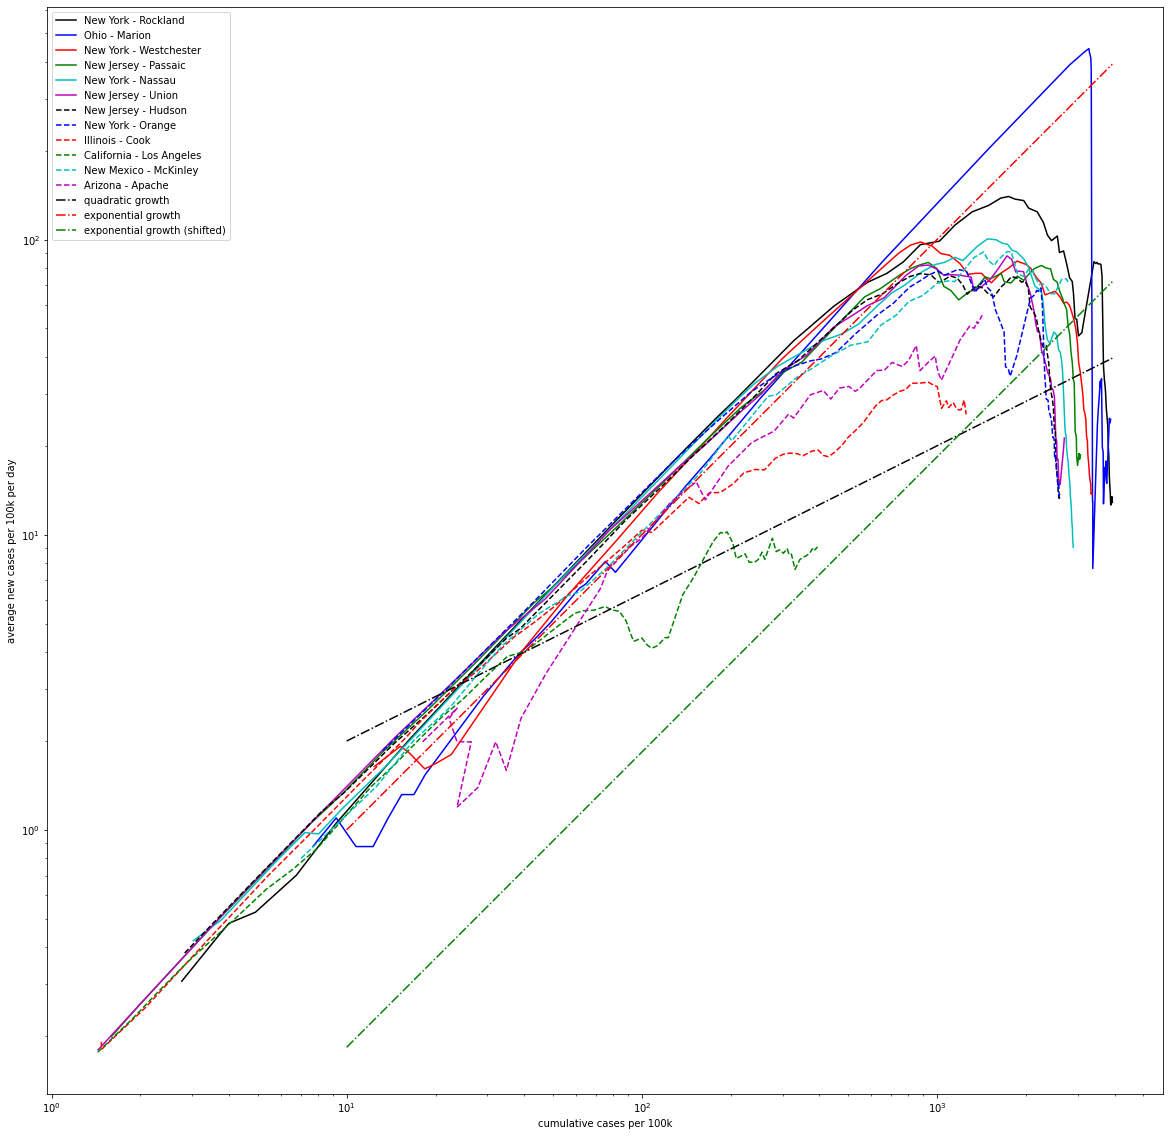

In [91]:
col_pick = ColorPicker()
plt.rcParams['figure.figsize'] = [20,20]
plt.axes().set_aspect('equal', 'datalim')
maxpt = 0.0
maxrate = 0.0
valid_counties = [c for c in counties.keys() if len(trajectory(c)[0]) > smoothing_window and c != 'Unknown']
valid_counties = sorted(valid_counties, key=lambda c: -1.0 * trajectory(c)[0][-1])
suffix = ""
if per_capita:
    suffix = " per 100k"
extra = [c for c in extra if c in valid_counties]
for county in top_n_from(valid_counties, extra, show_this_many_counties):
    t = trajectory(county)
    plot_traj(county, col_pick.get(), window=smoothing_window, suffix=suffix)
    print(county + " cumulative " + field + suffix + " : "+ str(trajectory(county)[0][-1]))
    try:
        doublings_per_day = np.log(t[0][-1]/t[0][-smoothing_window-1])/((t[2][-1] - t[2][-smoothing_window-1]) * np.log(2))
        days_to_double = 1.0/doublings_per_day
        print(county + " cumulative " + field + suffix +
              " currently doubles about once every {:.2f} days".format(days_to_double))
    except:
        print("Could not compute doublings per day for " + county)
    print("Last data entry for " + county + " was " + date_from_daynum(t[2][-1]).strftime("%Y-%m-%d"))
    maxpt = max(maxpt, t[0][-1])
    maxrate = max(maxrate, t[1][-1])

plt.plot([10.0, maxpt], [2.0, 2.0 * np.sqrt(0.1 * maxpt)], 'k-.', label="quadratic growth")
plt.plot([10.0, maxpt], [1.0, 0.1 * maxpt], 'r-.', label="exponential growth")
plt.plot([10.0, maxpt], [10.0 * maxrate / maxpt, maxrate], 'g-.', label="exponential growth (shifted)")
plt.legend()
print("shifted exponential reference line multiplies doubling time by " + str(0.1 * maxpt/maxrate))
print("curves lining up with upper exponential have doubling times of approximately " +
      "{:.2f}".format(np.log(2)/0.1) + " days")
print("curves lining up with lower exponential have doubling times of approximately " + 
      "{:.2f}".format(np.log(2)*maxpt/maxrate) + " days")
print("Because of how smoothing causes lag in cumulative case derivative,")
print("exponential rates seen on chart might not match computations.")
print("Charts should be used for qualitative analysis only at this point")

Time series plots
----------------------

And, for comparison, cumulative confirmed cases, by county, as a time series, on a semi-log (y log-scale, x linear) plot

New York - Rockland cumulative cases per 100k : 3928.3094272673416
Ohio - Marion cumulative cases per 100k : 3877.529073786736
New York - Westchester cumulative cases per 100k : 3348.9197999805688
New Jersey - Passaic cumulative cases per 100k : 3063.013873334582
New York - Nassau cumulative cases per 100k : 2895.8880526838643
New Mexico - McKinley cumulative cases per 100k : 2784.1999803830904
New Jersey - Union cumulative cases per 100k : 2701.760251356632
New Jersey - Hudson cumulative cases per 100k : 2620.647807600042
New York - Orange cumulative cases per 100k : 2598.5867927469217
New York - Suffolk cumulative cases per 100k : 2595.6233268161136
New York - New York City cumulative cases per 100k : 2365.876890105965
Nebraska - Hall cumulative cases per 100k : 2338.923932000065
Illinois - Cook cumulative cases per 100k : 1256.0790938973053
California - Los Angeles cumulative cases per 100k : 394.18844723938093
New Mexico - McKinley cumulative cases per 100k : 2784.1999803830904
Ari

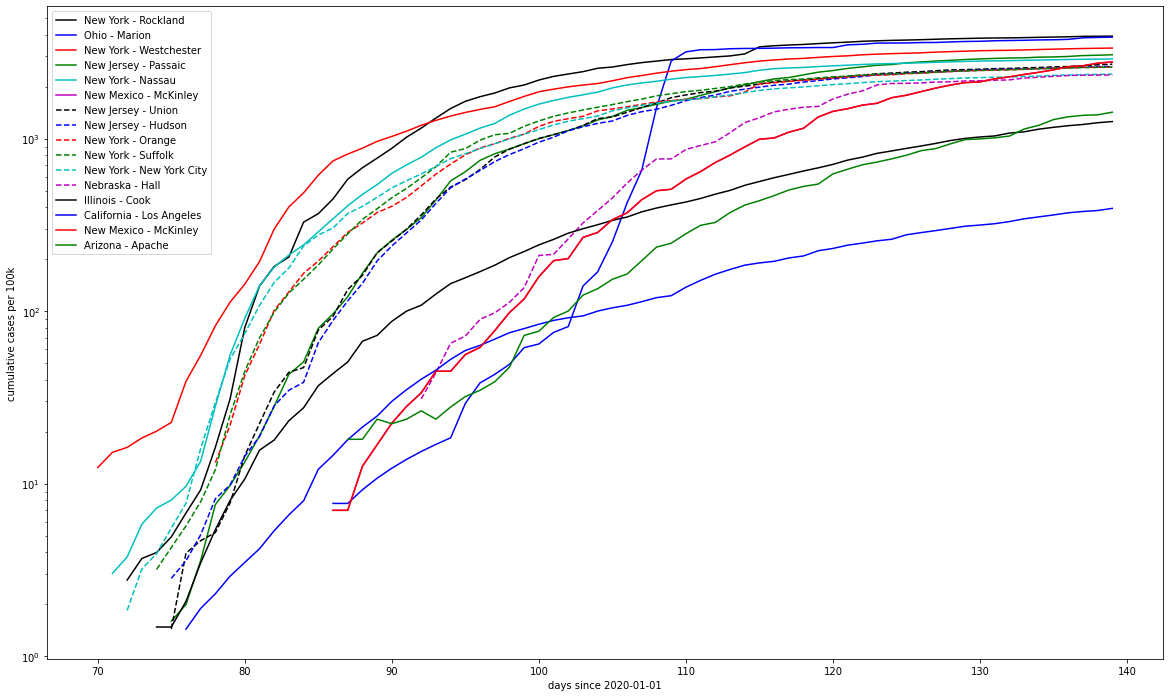

In [92]:
col_pick = ColorPicker()
phi = 0.5 * (1 + np.sqrt(5.0))
plt.rcParams['figure.figsize'] = [20,int(20/phi)]
maxpt = 0.0
maxrate = 0.0
valid_counties = [c for c in counties.keys() if len(trajectory(c)[0]) > smoothing_window and c != 'Unknown']
valid_counties = sorted(valid_counties, key=lambda c: -1.0 * trajectory(c)[0][-1])
extra = [c for c in counties.keys() if c.split(" - ")[-1] in extra_counties]
suffix = ""
if per_capita:
    suffix = " per 100k"
for county in valid_counties[:show_this_many_counties] + extra:
    t = trajectory(county)
    plot_time_series(county, col_pick.get(), window=smoothing_window, suffix=suffix)
    print(county + " cumulative " + field + suffix + " : "+ str(trajectory(county)[0][-1]))
    maxpt = max(maxpt, t[0][-1])
    maxrate = max(maxrate, t[1][-1])
plt.legend()